In [2]:
# Library includes
import os
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import random

import requests
import zipfile
from pathlib import Path
import tqdm

# Helper functions

from model_functions import *

from visualize_results import *

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Examine 
def walk_through_dir(dir_path):
    print("in walk through dir")
    """Walks through dir_path, returning its contents"""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

data_path = Path("../data")
image_path = data_path / "HEXIST V1/"
walk_through_dir(image_path)

in walk through dir
There are 2 directories and 1 images in ../data/HEXIST V1
There are 6 directories and 1 images in ../data/HEXIST V1/test
There are 0 directories and 17 images in ../data/HEXIST V1/test/wood
There are 0 directories and 17 images in ../data/HEXIST V1/test/sheep
There are 0 directories and 17 images in ../data/HEXIST V1/test/wheat
There are 0 directories and 13 images in ../data/HEXIST V1/test/brick
There are 0 directories and 6 images in ../data/HEXIST V1/test/desert
There are 0 directories and 13 images in ../data/HEXIST V1/test/ore
There are 6 directories and 1 images in ../data/HEXIST V1/train
There are 0 directories and 120 images in ../data/HEXIST V1/train/wood
There are 0 directories and 120 images in ../data/HEXIST V1/train/sheep
There are 0 directories and 120 images in ../data/HEXIST V1/train/wheat
There are 0 directories and 90 images in ../data/HEXIST V1/train/brick
There are 0 directories and 50 images in ../data/HEXIST V1/train/desert
There are 0 director

In [4]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('../data/HEXIST V1/train'), PosixPath('../data/HEXIST V1/test'))

In [5]:
from torchvision.transforms import v2

train_data_transform = v2.Compose([
    v2.Resize(size=(40, 40)),
    v2.RandomRotation(degrees=180, interpolation=transforms.InterpolationMode.BILINEAR),
    v2.RandomApply([transforms.GaussianBlur(kernel_size=17, sigma=(0.5, 1.5))], p=0.8),
    v2.ToTensor()
])

test_data_transform = v2.Compose([
    v2.Resize(size=(40, 40)),
    v2.ToTensor()
])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [6]:
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_data_transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=test_data_transform,
                                 target_transform=None)
class_names = train_data.classes

len(train_data), len(test_data), class_names

(590, 77, ['brick', 'desert', 'ore', 'sheep', 'wheat', 'wood'])

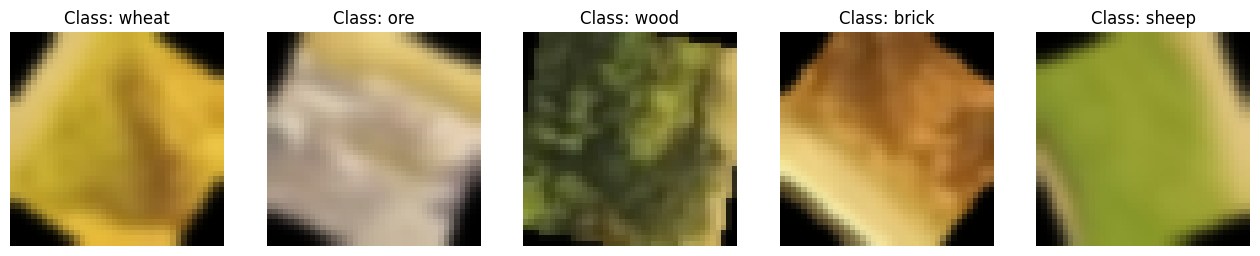

In [25]:
display_random_images(dataset=train_data,
                      classes=class_names,
                      n=5,
                      display_shape=False)

In [7]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x2912c4e50>,
 <torch.utils.data.dataloader.DataLoader at 0x291c67390>)

In [8]:
device = ("cuda" if torch.cuda.is_available()
        else "mps" if torch.backends.mps.is_available()
        else "cpu"
    )
device

'mps'

In [9]:
from resnet import BasicBlock, ResNet

In [10]:
test_model = ResNet(input_shape=3,
                    block=BasicBlock,
                    layers=[2,2,2],
                    class_cnt=len(class_names)).to(device)

In [11]:
# Get a test image to make sure the images work with the model architecture
image_batch, label_batch = next(iter(test_dataloader))
# image_batch.shape, label_batch.shape
test_model(image_batch.to(device))

tensor([[-0.3325,  0.5362, -0.0751, -0.4373, -0.0247, -0.5746],
        [-0.2736,  0.6116, -0.0722, -0.4421,  0.0200, -0.5650],
        [-0.2826,  0.5313, -0.0237, -0.4838, -0.0387, -0.5635],
        [-0.1117,  0.5509,  0.0060, -0.4392, -0.1049, -0.4445],
        [-0.1848,  0.5495, -0.0914, -0.4668, -0.1546, -0.4550],
        [-0.2743,  0.4856,  0.0070, -0.3559, -0.2056, -0.4177],
        [-0.3431,  0.4872, -0.0660, -0.4979, -0.0470, -0.6871],
        [-0.1874,  0.5648,  0.0326, -0.2893, -0.2577, -0.3793],
        [-0.2325,  0.5211, -0.0664, -0.4638, -0.0898, -0.5729],
        [-0.2129,  0.5443, -0.0260, -0.4792, -0.0345, -0.5303],
        [-0.2404,  0.4547,  0.1191, -0.5698, -0.0431, -0.5455],
        [-0.1242,  0.5181,  0.0024, -0.5205, -0.1275, -0.5311],
        [-0.3480,  0.3555, -0.0762, -0.4531, -0.1139, -0.6018],
        [-0.1816,  0.2320, -0.0837, -0.4864, -0.2429, -0.5106],
        [-0.2890,  0.3349, -0.0869, -0.4217, -0.1251, -0.5598],
        [-0.2629,  0.2980, -0.0138, -0.4

In [12]:
# Model Variables
INPUT_SHAPE = 3
OUTPUT_SHAPE = len(class_names)
# Hyperparameters (Batch size is in cell 27)
EPOCHS = 10
LR = 0.001
LOSS_FN = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam

In [13]:
# Train the model
hexistV1 = ResNet(input_shape=INPUT_SHAPE,
                  block=BasicBlock,
                  layers=[2, 2, 2],
                  class_cnt=OUTPUT_SHAPE).to(device)

model_optimizer = optimizer(hexistV1.parameters(), lr=LR)

# Start a timer to track train time
from timeit import default_timer as timer
start_time = timer()

# Train the simple model
hexistV1_results = train(model=hexistV1,
                         train_dataloader=train_dataloader,
                         test_dataloader=test_dataloader,
                         optimizer=model_optimizer,
                         loss_fn=LOSS_FN,
                         epochs=EPOCHS,
                         device=device)

# End the timer
end_time = timer()
print(f"hexistV1 Training time: {end_time-start_time:.3f} seconds")

 10%|█         | 1/10 [00:01<00:16,  1.86s/it]

Epoch: 1 | train_loss: 0.5712 | train_acc: 0.7857 | test_loss: 7.0133 | test_acc: 0.1506


 20%|██        | 2/10 [00:03<00:11,  1.50s/it]

Epoch: 2 | train_loss: 0.2183 | train_acc: 0.9255 | test_loss: 0.5889 | test_acc: 0.7917


 30%|███       | 3/10 [00:04<00:09,  1.40s/it]

Epoch: 3 | train_loss: 0.1595 | train_acc: 0.9474 | test_loss: 1.0182 | test_acc: 0.6827


 40%|████      | 4/10 [00:05<00:08,  1.34s/it]

Epoch: 4 | train_loss: 0.1343 | train_acc: 0.9662 | test_loss: 2.0074 | test_acc: 0.6939


 50%|█████     | 5/10 [00:06<00:06,  1.31s/it]

Epoch: 5 | train_loss: 0.1430 | train_acc: 0.9547 | test_loss: 0.4605 | test_acc: 0.8910


 60%|██████    | 6/10 [00:08<00:05,  1.30s/it]

Epoch: 6 | train_loss: 0.1191 | train_acc: 0.9490 | test_loss: 0.9219 | test_acc: 0.8125


 70%|███████   | 7/10 [00:09<00:03,  1.29s/it]

Epoch: 7 | train_loss: 0.0847 | train_acc: 0.9737 | test_loss: 0.0154 | test_acc: 1.0000


 80%|████████  | 8/10 [00:10<00:02,  1.29s/it]

Epoch: 8 | train_loss: 0.0208 | train_acc: 0.9984 | test_loss: 0.0827 | test_acc: 0.9792


 90%|█████████ | 9/10 [00:11<00:01,  1.28s/it]

Epoch: 9 | train_loss: 0.0619 | train_acc: 0.9819 | test_loss: 0.0029 | test_acc: 1.0000


100%|██████████| 10/10 [00:13<00:00,  1.32s/it]

Epoch: 10 | train_loss: 0.0422 | train_acc: 0.9864 | test_loss: 0.0581 | test_acc: 0.9896
hexistV1 Training time: 13.222 seconds


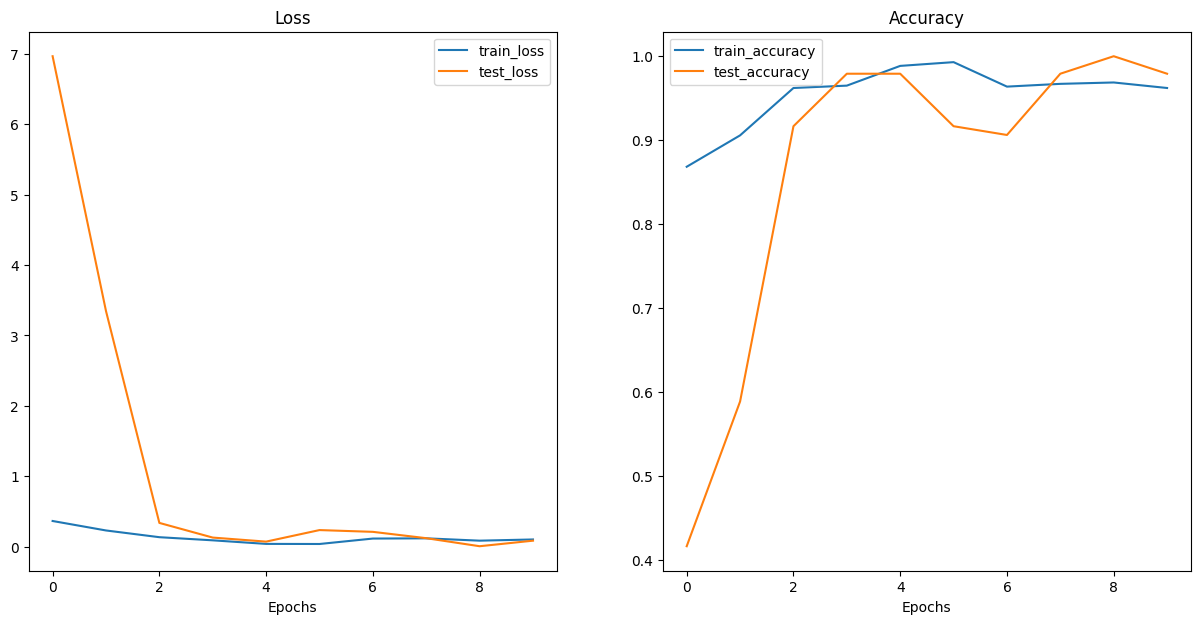

In [ ]:
plot_loss_curves(hexistV1_results)

In [ ]:
custom_image_path = "../images/eval hexes/018.jpg"
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)
custom_image /= 255

custom_image_transform = transforms.Compose([
    transforms.Resize(size=(40, 40))
])

custom_image_transformed = custom_image_transform(custom_image[:3, :, :])

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 40, 40])
New shape: torch.Size([3, 40, 40])


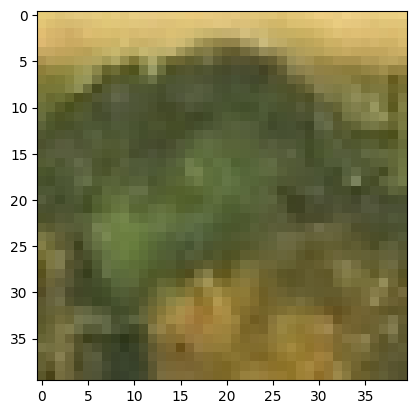

In [ ]:
plt.imshow(custom_image_transformed.permute(1, 2, 0))

In [ ]:
class_names

['brick', 'desert', 'ore', 'sheep', 'wheat', 'wood']

In [ ]:
hexistV1.eval()
with torch.inference_mode():
    custom_image_pred = hexistV1(custom_image_transformed.unsqueeze(0).to(device))
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction class: {class_names[custom_image_pred_label]}")

Prediction class: wood


# Save the model

In [ ]:
from pathlib import Path 

# Create model directory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create the model save path
MODEL_NAME = "hexistV1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model's state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=hexistV1.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/hexistV1.pth


In [ ]:
class_names

['brick', 'desert', 'ore', 'sheep', 'wheat', 'wood']